In [1]:
# For Colab
import sys
if 'google.colab' in sys.modules:
    !pip -q install geopandas ortools
    !curl -O https://raw.githubusercontent.com/pjrule/covid-path-planning/master/miller_223.geojson
    !apt -q install imagemagick
else:
    !pip -q install geopandas cvxpy matplotlib scipy ortools jax jaxlib

In [1]:
%config InlineBackend.figure_formats = ['svg']
import cvxpy as cp
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from scipy.spatial import distance_matrix
from scipy.optimize import minimize
from scipy.misc import derivative
from room import Room, Path, animate_path

In [2]:
scale = 5
hexagon = Polygon([(scale * np.cos(idx * np.pi / 3), scale * np.sin(idx * np.pi / 3))
                   for idx in range(6)])
gdf = gpd.GeoDataFrame({'name': ['hexagon'], 'type': ['room'], 'geometry': [hexagon]})

In [3]:
min_intensity = 0.1
height = 0.2

In [4]:
room = Room(gdf,
            guard_scale=0.8,
            room_res=1,
            guard_res=200)

## Finding the dimmest point

In [5]:
max_room_points = 25

In [6]:
room_points = np.zeros((max_room_points, 2))
room_intensities = np.zeros((max_room_points, room.guard_grid.shape[0]))
room_points_idx = 0

In [7]:
exterior_points = room.room.exterior.coords.xy

for x, y in zip(exterior_points[0][:-1], exterior_points[1][:-1]):
    room_points[room_points_idx] = (x, y)
    room_intensities[room_points_idx] = 1 / ((room.guard_grid[:, 0] - x)**2 +
                                             (room.guard_grid[:, 1] - y)**2 +
                                             height)
    room_points_idx += 1

In [8]:
def solve_lp():
    loc_times = cp.Variable(room.guard_grid.shape[0])
    obj = cp.Minimize(cp.sum(loc_times))
    constraints = [
        room_intensities[:room_points_idx] @ loc_times >= min_intensity,
        loc_times >= 0
    ]
    prob = cp.Problem(obj, constraints=constraints)
    prob.solve(solver='ECOS')
    return loc_times.value

In [9]:
weights = solve_lp()

Let $\textbf{w}_i$ denote the weight of the $i$th guard point ($g_i$). Then for $(x, y) \in G$, where $G$ is the interior of the room (assumed to be convex), we have

\begin{equation*}
I(x, y) = \sum_{i=1}^n \frac{w_i}{(x - g_{i,x})^2 + (y - g_{i,y})^2}
\end{equation*}

So
\begin{align*}
\frac{\partial I}{\partial x} &= -2 \sum_{i=1}^n \frac{w_i (x - g_{i,x})}{\Big((x - g_{i,x})^2 + (y - g_{i,y})^2\Big)^2} \\
\frac{\partial I}{\partial y} &= -2 \sum_{i=1}^n \frac{w_i (y - g_{i,y})}{\Big((x - g_{i,x})^2 + (y - g_{i,y})^2\Big)^2}
\end{align*}

Strategy:
* Brute force on a grid; for each subregion, compute bounds on derivatives, using the grid point as the (approximate) center.

What we're really looking for here is the existence of a missing point with a gradient of 0. Question to answer: for each subregion, is it even possible to have such a point? If so, more than one?

In [10]:
def illumination(p, weights):
    """Inverse-square illumination function."""
    x, y = p
    if not room.room.contains(Point(x, y)):
        return 0 #1 / height
    
    x_dist = x - room.guard_grid[:, 0]
    y_dist = y - room.guard_grid[:, 1]
    distances = x_dist**2 + y_dist**2 + height
    return np.sum(weights * distances**-1)

In [12]:
def d_illumination(p, weights):
    """Jacobian of the illumination function."""
    x, y = p
    if not room.room.contains(Point(x, y)):
        return np.zeros(2)
    
    x_dist = x - room.guard_grid[:, 0]
    y_dist = y - room.guard_grid[:, 1]
    distances = x_dist**2 + y_dist**2 + height
    
    dx = -2 * np.sum(weights * distances**-2 * x_dist)
    dy = -2 * np.sum(weights * distances**-2 * y_dist)
    return np.array([dx, dy])

In [14]:
d_illumination((0, 0), weights)

array([-0.0000000e+00, -3.2959746e-17])

In [13]:
def d2_illumination(p, weights):
    """Hessian of the illumination function."""
    x, y = p
    if not room.room.contains(Point(x, y)):
        return np.zeros((2, 2))
    
    x_dist = x - room.guard_grid[:, 0]
    y_dist = y - room.guard_grid[:, 1]
    distances = x_dist**2 + y_dist**2 + height
    
    dx2 = np.sum((8 * weights * distances**-3 * x_dist**2) -
                 (2 * weights * distances**-2))
    dy2 = np.sum((8 * weights * distances**-3 * y_dist**2) -
                 (2 * weights * distances**-2))
    dx_dy = np.sum(8 * weights * distances**-3 * x_dist * y_dist)
    return np.array([[dx2, dx_dy], [dx_dy, dy2]])

In [14]:
n = 401
X, Y = np.meshgrid(np.linspace(-scale, scale, n), np.linspace(-scale, scale, n))
Z = np.zeros(n * n)
for idx, (x, y) in enumerate(zip(X.flatten(), Y.flatten())):
    Z[idx] = illumination([x, y], weights)

In [15]:
plt.contour(X, Y, Z.reshape(n, n), 300, cmap='RdGy')

In [16]:
Z_fixed = Z.copy()
Z_fixed[Z_fixed==0] = Z_fixed.max()
Z_fixed.min()

0.0576355595446397

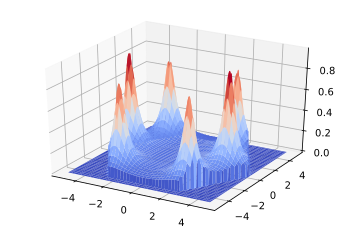

In [17]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z.reshape(n, n), cmap='coolwarm',
                       linewidth=0, antialiased=False)
plt.show()

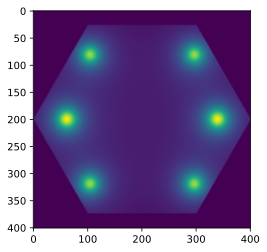

In [18]:
plt.imshow(Z.reshape(n, n))
plt.show()

## Iteratively refining the room points

In [21]:
def dimmest_point(weights, x0=None, alpha=0.01, k=10000):
    if x0 is None:
        x0 = 3 * np.random.random(2)
    x = x0
    for _ in range(k):
        x -= alpha * d_illumination(x, weights)
    return x

times = []
for idx in range(room_points_idx, max_room_points):
    weights = solve_lp()
    n = 101
    X, Y = np.meshgrid(np.linspace(-scale, scale, n), np.linspace(-scale, scale, n))
    X = X.flatten()
    Y = Y.flatten()
    Z = np.zeros(n * n)
    for z_idx, (x, y) in enumerate(zip(X, Y)):
        Z[z_idx] = illumination([x, y], weights)
    Z[Z == 0] = Z.max()
    x0 = X[np.argmin(Z)]
    y0 = Y[np.argmin(Z)]
    x, y = dimmest_point(weights, x0=(x0, y0))    
    if not room.room.contains(Point(x, y)):
        print('outside! using approx')
    x = x0
    y = y0
        
    print('min illumination:', illumination((x, y), weights))
    times.append(weights.sum() * (min_intensity / illumination((x, y), weights)))
    print(times[-1])
    room_points[idx] = (x, y)
    room_intensities[idx] = 1 / ((room.guard_grid[:, 0] - x)**2 +
                                 (room.guard_grid[:, 1] - y)**2 +
                                 height)
    room_points_idx += 1

0.0 4.300000000000001 0.0581030628864924
outside! :(
min illumination: 0


ZeroDivisionError: float division by zero